In [15]:
import tqdm
import torch.nn as nn
import torch
from torch.optim import SGD
from torch.optim import RMSprop
from torch.optim import Adam
import math
import numpy as np
import csv
import re
import matplotlib.pyplot as plt
import torch.utils.tensorboard as tensorboard
from torch.autograd import Variable  
import datetime

In [60]:
#1時間ごとでの
with open('2022_nikkei_225.csv') as f:
    reader = csv.reader(f)
    l = [row for row in reader]
    t_dataes = [re.findall(r'\d+', l[i][1]) for i in range(2, len(l))]
    time = [int(t_dataes[i][0]) * 24 + int(t_dataes[i][1]) for i in range(0, len(t_dataes))]
    m_begin = [int(l[i][2]) for i in range(2, len(l))]
    m_end = [int(l[i][3]) for i in range(2, len(l))]
    m_low = [int(l[i][4]) for i in range(2, len(l))]
    m_high = [int(l[i][5]) for i in range(2, len(l))]
    m_turnover = [int(l[i][6]) for i in range(2, len(l))]
    minuites_data = [time, m_begin, m_end, m_low, m_high, m_turnover]
    m_data = np.array(minuites_data)

In [61]:
def normalization(data):
    avg = np.mean(data)
    std = np.std(data)
    data = (data - avg) / std
    return data

In [62]:
m_data = normalization(m_data)

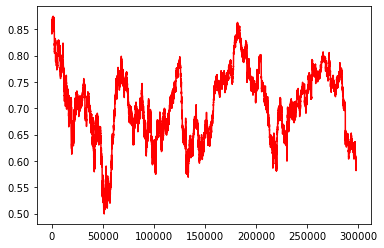

In [63]:
fig = plt.figure()
ax = fig.add_subplot(111)

ax.plot(m_data[1], color = "r")

In [64]:
window = 10 # 移動平均の範囲
w = np.ones(window)/window

m_data_convolve = []
for i, data in enumerate(m_data):
    if i == 0 or i == len(m_data) - 1:
        m_data_convolve.append(data)
    else:
        m_data_convolve.append(np.convolve(data, w, mode='same'))

m_data_convolve = np.array(m_data_convolve)

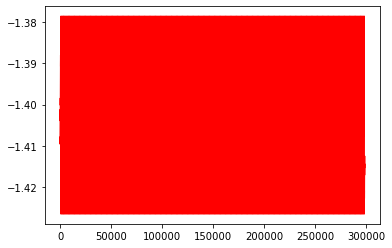

In [65]:
fig = plt.figure()
ax = fig.add_subplot(111)

ax.plot(m_data_convolve[0], color = "r")

In [ ]:
m_data_convolve = m_data_convolve.transpose(1, 0)

In [7]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(torch.cuda.is_available())

True


In [8]:
def value_s(np_array, rate = 0.9):
    sum = 0
    if (len(np_array) < 100):
        for n, r in enumerate(np_array):
            sum += rate ** n * (r - np_array[0])
    else:
        for n in range(100):
            sum += rate ** n * (np_array[n] - np_array[0])
    return sum

def mkDataSet(data_size, data_length):
    train_x = []
    train_t = []
    for offset in range(data_size // 100):
        train_x.append([[m_data_convolve[offset * 100 + i]] for i in range(data_length)])
        train_t.append([value_s(m_data_convolve[offset * 100 + data_length:-1])])
        
    return np.array(train_x), np.array(train_t)

def mkBatchSet(train_x, train_t, batch_size):
    batch_x = []
    batch_t = []    
    for _ in range(batch_size):
        idx = np.random.randint(0, len(train_x)-1)
        batch_x.append(train_x[idx])
        batch_t.append(train_t[idx])
        
    batch_x = np.array(batch_x).astype(np.float32)
    batch_t = np.array(batch_t).astype(np.float32)

    return torch.from_numpy(batch_x).clone().reshape(batch_size, 1, -1).to(device), torch.from_numpy(batch_t).clone().to(device)

In [13]:
data_length = 10000
training_size = len(m_data)-data_length
epoch_num = 100000
hidden_size = 10
batch_size = 32

train_x, train_t = mkDataSet(training_size, data_length)
data, label = mkBatchSet(train_x, train_t, batch_size)

In [14]:
class Predictor(nn.Module):
    def __init__(self, inputDim, hiddenDim, outputDim):
        super(Predictor, self).__init__()
        self.hiddenDim = hiddenDim
        self.kernel_size1 = 5000
        self.kernel_size2 = 2500
        self.kernel_size3 = 500
        self.kernel_size4 = 250
        self.kernel_size5 = 100
        self.kernel_size6 = 50
        self.seq_len = ((inputDim - self.kernel_size1 + 1 - self.kernel_size2 + 1) // 2 - self.kernel_size3 + 1 - self.kernel_size4 + 1) // 2 - self.kernel_size5 + 1 - self.kernel_size6 + 1
        
        self.conv1d_1 = nn.Conv1d(1, 16, self.kernel_size1)
        self.conv1d_2 = nn.Conv1d(16, 32, self.kernel_size2)
        self.max_pool1 = nn.MaxPool1d(2)
        self.conv1d_3 = nn.Conv1d(32, 64, self.kernel_size3)
        self.conv1d_4 = nn.Conv1d(64, 64, self.kernel_size4)
        self.max_pool2 = nn.MaxPool1d(2)
        self.conv1d_5 = nn.Conv1d(64, 64, self.kernel_size5)
        self.conv1d_6 = nn.Conv1d(64, 64, self.kernel_size6)
        self.rnn1 = nn.LSTM(input_size=64, hidden_size=hiddenDim, batch_first=True) #batch_first=Trueで(seq, batch, vec)->(batch, seq, vec)に入力の形を変更
        self.rnn2 = nn.LSTM(input_size=hiddenDim, hidden_size=hiddenDim, batch_first=True) #batch_first=Trueで(seq, batch, vec)->(batch, seq, vec)に入力の形を変更
        self.output_layer = nn.Linear(hiddenDim, outputDim)

    def forward(self, input):
        output = self.conv1d_1(input)
        output = self.conv1d_2(output)
        output = self.maxpool1(output)
        output = self.conv1d_3(output)
        output = self.conv1d_4(output)
        output = self.maxpool2(output)
        output = self.conv1d_5(output)
        output = self.conv1d_6(output)
        h_0_1 = None
        output = output.reshape(-1, self.seq_len, 64)
        output, (hidden, cell) = self.rnn1(output, (h_0_1)) #LSTMのforwardのreturnはこのような戻り値になっている
        h_0_2 = None
        output, (hidden, cell) = self.rnn2(output, (h_0_2))
        output = self.output_layer(output[:, -1, :]) #LSTMのoutput=(batch, seq, hidden)からseqのみ最後のやつだけを取り出す
        return output

In [15]:
model = Predictor(data_length, hidden_size, 1).to(device)
criterion = nn.MSELoss()
optimizer = Adam(model.parameters(), lr=0.001)

In [20]:
loss_history = []
for epoch in tqdm.tqdm(range(epoch_num)):
    optimizer.zero_grad()
    data, label = mkBatchSet(train_x, train_t, batch_size)
    output = model(data)

    loss = criterion(output, label)
    loss.backward()
    optimizer.step()

    running_loss = torch.sum(loss.data)
    loss_history.append(running_loss.to('cpu').detach().numpy().copy())
    
    if (epoch+1) % 1000 == 0:
        print('%d loss: %3f' % (epoch+1, running_loss))

  1% 1000/100000 [03:26<5:42:41,  4.81it/s]

1000 loss: 0.080435


  2% 2000/100000 [06:54<5:38:36,  4.82it/s]

2000 loss: 0.050720


  3% 3000/100000 [10:21<5:35:20,  4.82it/s]

3000 loss: 0.042026


  5% 5000/100000 [17:16<5:28:19,  4.82it/s]

5000 loss: 0.027643


  6% 6000/100000 [20:44<5:25:00,  4.82it/s]

6000 loss: 0.029499


  7% 7000/100000 [24:11<5:21:22,  4.82it/s]

7000 loss: 0.042686


  7% 7184/100000 [24:49<5:20:48,  4.82it/s]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

 20% 20000/100000 [1:09:09<4:36:39,  4.82it/s]

20000 loss: 0.057178


 21% 21000/100000 [1:12:37<4:33:28,  4.81it/s]

21000 loss: 0.026908


 22% 22000/100000 [1:16:04<4:29:27,  4.82it/s]

22000 loss: 0.017223


 23% 22668/100000 [1:18:23<4:27:17,  4.82it/s]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

 36% 36000/100000 [2:04:28<3:41:13,  4.82it/s]

36000 loss: 0.042487


 37% 37000/100000 [2:07:56<3:37:28,  4.83it/s]

37000 loss: 0.045951


 38% 38000/100000 [2:11:23<3:34:14,  4.82it/s]

38000 loss: 0.119839


 38% 38171/100000 [2:11:59<3:33:32,  4.83it/s]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

 50% 50000/100000 [2:52:52<2:52:52,  4.82it/s]

50000 loss: 0.031152


 51% 51000/100000 [2:56:19<2:49:29,  4.82it/s]

51000 loss: 0.019911


 52% 52000/100000 [2:59:47<2:45:39,  4.83it/s]

52000 loss: 0.016257


 53% 52840/100000 [3:02:41<2:42:51,  4.83it/s]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

 66% 66000/100000 [3:48:10<1:57:31,  4.82it/s]

66000 loss: 0.020638


 67% 67000/100000 [3:51:37<1:54:03,  4.82it/s]

67000 loss: 0.024116


 68% 68000/100000 [3:55:05<1:50:34,  4.82it/s]

68000 loss: 0.021763


 68% 68312/100000 [3:56:09<1:49:30,  4.82it/s]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

 81% 81000/100000 [4:40:02<1:05:42,  4.82it/s]

81000 loss: 0.015075


 82% 82000/100000 [4:43:29<1:02:12,  4.82it/s]

82000 loss: 0.032632


 83% 83000/100000 [4:46:57<58:50,  4.82it/s]  

83000 loss: 0.013016


 84% 83562/100000 [4:48:53<56:48,  4.82it/s]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

 96% 96000/100000 [5:31:52<13:48,  4.83it/s]

96000 loss: 0.016444


 97% 97000/100000 [5:35:20<10:22,  4.82it/s]

97000 loss: 0.029470


 98% 98000/100000 [5:38:47<06:54,  4.83it/s]

98000 loss: 0.030339


 99% 98714/100000 [5:41:15<04:26,  4.82it/s]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



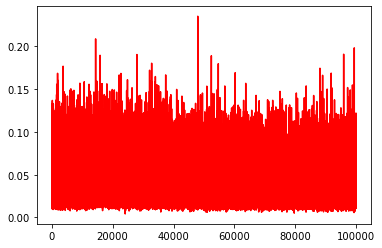

In [23]:
loss_history = np.array(loss_history)
fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(loss_history, color = "r")

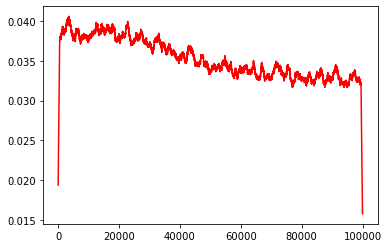

In [28]:
window = 1000 # 移動平均の範囲
w = np.ones(window)/window

loss_hist_convolve = np.convolve(loss_history, w, mode='same')

fig = plt.figure()
ax = fig.add_subplot(111)

ax.plot(loss_hist_convolve, color = "r")

In [81]:
def mkValidDataSet(valid_data_size, data_length, idx):
    train_x = []
    train_t = []
    
    for offset in range(valid_data_size):
        train_x.append([[m_data_convolve[idx + offset]] for i in range(data_length)])
        
    return np.array(train_x)

In [83]:
valid_data_size = 1000
reward_avg = 0.

with torch.no_grad():
    for _ in range(100):
        state = 0 #0->1で買い　1->0で売り
        reward = 0.
        last_output = 0.
        buy_chart = 0.
        idx = int(np.random.randint(0, len(m_data_convolve) - valid_data_size - 1))
        test_data = mkValidDataSet(valid_data_size, data_length, idx)
        for data in tqdm.tqdm(test_data):
            output = model(torch.from_numpy(data.astype(np.float32)).clone().reshape(1, 1, -1).to(device))
            if output.data > last_output:
                if state == 0:
                    reward += data[-1][0] - buy_chart
                state = 1
            else:
                if state == 1:
                    buy_chart = data[-1][0]
                state = 0
            last_output = output.data
        
        print(reward)
        reward_avg += reward

100% 1000/1000 [00:06<00:00, 155.15it/s]


-0.9780815118240062


100% 1000/1000 [00:06<00:00, 155.24it/s]


0.9181110379427269


100% 1000/1000 [00:06<00:00, 155.49it/s]


0.008411185406661855


100% 1000/1000 [00:06<00:00, 155.13it/s]


0.04149118004433697


100% 1000/1000 [00:06<00:00, 154.67it/s]


1.6931280551682577


100% 1000/1000 [00:06<00:00, 155.47it/s]


0.5565939536881348


100% 1000/1000 [00:06<00:00, 154.69it/s]


-1.5026357125071397


100% 1000/1000 [00:06<00:00, 154.33it/s]


-0.031757379510515035


100% 1000/1000 [00:06<00:00, 154.76it/s]


-1.271075750043414


100% 1000/1000 [00:06<00:00, 154.58it/s]


1.2430038424198928


100% 1000/1000 [00:06<00:00, 154.48it/s]


0.8862124716849686


100% 1000/1000 [00:06<00:00, 154.07it/s]


-1.0418786443395225


100% 1000/1000 [00:06<00:00, 154.05it/s]


-1.271075750043414


100% 1000/1000 [00:06<00:00, 153.94it/s]


-0.9816257969637571


100% 1000/1000 [00:06<00:00, 154.29it/s]


1.9554051555098244


100% 1000/1000 [00:06<00:00, 153.98it/s]


-0.4050887475642768


100% 1000/1000 [00:06<00:00, 154.22it/s]


-1.0938614930558686


100% 1000/1000 [00:06<00:00, 153.70it/s]


-1.4589228624502122


100% 1000/1000 [00:06<00:00, 154.25it/s]


-1.495547142227638


100% 1000/1000 [00:06<00:00, 153.99it/s]


0.15018259099669795


100% 1000/1000 [00:06<00:00, 153.94it/s]


-0.9131029509285729


100% 1000/1000 [00:06<00:00, 154.00it/s]


-1.4731000030092158


100% 1000/1000 [00:06<00:00, 153.73it/s]


-0.7866901142774572


100% 1000/1000 [00:06<00:00, 153.45it/s]


1.3481509682325028


100% 1000/1000 [00:06<00:00, 153.53it/s]


0.052124035463589666


100% 1000/1000 [00:06<00:00, 153.35it/s]


-0.11563879448461972


100% 1000/1000 [00:06<00:00, 153.83it/s]


0.9748196001787414


100% 1000/1000 [00:06<00:00, 153.55it/s]


0.46089825491486036


100% 1000/1000 [00:06<00:00, 153.88it/s]


-2.269382731073252


100% 1000/1000 [00:06<00:00, 153.74it/s]


-0.6366487100280025


100% 1000/1000 [00:06<00:00, 153.04it/s]


-0.8044115399762116


100% 1000/1000 [00:06<00:00, 153.35it/s]


0.951191032580402


100% 1000/1000 [00:06<00:00, 153.57it/s]


-0.034120236270348964


100% 1000/1000 [00:06<00:00, 153.41it/s]


-0.3531058988479302


100% 1000/1000 [00:06<00:00, 153.68it/s]


-0.9674486564047534


100% 1000/1000 [00:06<00:00, 153.62it/s]


0.5294211009500445


100% 1000/1000 [00:06<00:00, 153.75it/s]


1.8207223201992904


100% 1000/1000 [00:06<00:00, 153.50it/s]


-0.047115948449435605


100% 1000/1000 [00:06<00:00, 153.97it/s]


0.03322118138491816


100% 1000/1000 [00:06<00:00, 153.78it/s]


-0.037664521410099905


100% 1000/1000 [00:06<00:00, 153.25it/s]


-0.33892875828892655


100% 1000/1000 [00:06<00:00, 153.06it/s]


-0.028213094370764136


100% 1000/1000 [00:06<00:00, 153.29it/s]


0.03912832328450302


100% 1000/1000 [00:06<00:00, 153.26it/s]


-1.7401028168704498


100% 1000/1000 [00:06<00:00, 153.51it/s]


1.4485723805254451


100% 1000/1000 [00:06<00:00, 153.49it/s]


-0.49842158957771715


100% 1000/1000 [00:06<00:00, 153.86it/s]


0.02967689624516729


100% 1000/1000 [00:06<00:00, 153.66it/s]


-1.5664328450226561


100% 1000/1000 [00:06<00:00, 153.87it/s]


1.7155751943866802


100% 1000/1000 [00:06<00:00, 153.72it/s]


-1.0855914943964498


100% 1000/1000 [00:06<00:00, 153.72it/s]


0.9795453136984092


100% 1000/1000 [00:06<00:00, 153.47it/s]


-1.0442415010993562


100% 1000/1000 [00:06<00:00, 153.64it/s]


-1.2899786041220853


100% 1000/1000 [00:06<00:00, 153.38it/s]


-0.5007844463375511


100% 1000/1000 [00:06<00:00, 153.45it/s]


0.6735553632999146


100% 1000/1000 [00:06<00:00, 153.47it/s]


-0.43580588544211785


100% 1000/1000 [00:06<00:00, 153.60it/s]


0.7846096310121095


100% 1000/1000 [00:06<00:00, 153.41it/s]


-0.03175737951051502


100% 1000/1000 [00:06<00:00, 153.42it/s]


0.7952424864313622


100% 1000/1000 [00:06<00:00, 153.39it/s]


-1.3667714488166884


100% 1000/1000 [00:06<00:00, 153.58it/s]


0.547142526648799


100% 1000/1000 [00:06<00:00, 153.65it/s]


-1.0855914943964498


100% 1000/1000 [00:06<00:00, 153.75it/s]


-2.2752898729728366


100% 1000/1000 [00:06<00:00, 153.75it/s]


-2.4761326975587203


100% 1000/1000 [00:06<00:00, 153.85it/s]


0.6062139456446475


100% 1000/1000 [00:06<00:00, 153.69it/s]


1.7380223336051024


100% 1000/1000 [00:06<00:00, 153.81it/s]


2.085362277300691


100% 1000/1000 [00:06<00:00, 153.25it/s]


0.697183930898254


100% 1000/1000 [00:06<00:00, 153.33it/s]


0.029676896245167256


100% 1000/1000 [00:06<00:00, 153.93it/s]


-0.7429772642205293


100% 1000/1000 [00:06<00:00, 153.28it/s]


-0.11445736610470275


100% 1000/1000 [00:06<00:00, 153.70it/s]


2.247217965349315


100% 1000/1000 [00:06<00:00, 153.60it/s]


0.032039753005001205


100% 1000/1000 [00:06<00:00, 153.52it/s]


1.3611466804115895


100% 1000/1000 [00:06<00:00, 153.62it/s]


-0.027031665990847154


100% 1000/1000 [00:06<00:00, 153.58it/s]


-2.608452676109421


100% 1000/1000 [00:06<00:00, 153.35it/s]


0.9311067501218135


100% 1000/1000 [00:06<00:00, 153.72it/s]


-0.03293880789043197


100% 1000/1000 [00:06<00:00, 153.40it/s]


-0.06720023090802403


100% 1000/1000 [00:06<00:00, 153.07it/s]


-0.006947383532258711


100% 1000/1000 [00:06<00:00, 153.85it/s]


-0.6366487100280026


100% 1000/1000 [00:06<00:00, 153.48it/s]


-0.5326830125953093


100% 1000/1000 [00:06<00:00, 153.95it/s]


-0.947364373946165


100% 1000/1000 [00:06<00:00, 153.74it/s]


0.042672608424253924


100% 1000/1000 [00:06<00:00, 153.83it/s]


0.9653681731394056


100% 1000/1000 [00:06<00:00, 153.46it/s]


0.6676482214003299


100% 1000/1000 [00:06<00:00, 153.18it/s]


-0.9544529442256667


100% 1000/1000 [00:06<00:00, 153.71it/s]


0.2541482884293911


100% 1000/1000 [00:06<00:00, 153.75it/s]


0.04149118004433692


100% 1000/1000 [00:06<00:00, 153.59it/s]


-1.0265200754006019


100% 1000/1000 [00:06<00:00, 153.77it/s]


0.7172682133568423


100% 1000/1000 [00:06<00:00, 153.23it/s]


-0.05656737548877133


100% 1000/1000 [00:06<00:00, 153.82it/s]


0.7739767755928568


100% 1000/1000 [00:06<00:00, 153.49it/s]


-0.017580238951511434


100% 1000/1000 [00:06<00:00, 153.55it/s]


-0.0435716633096847


100% 1000/1000 [00:06<00:00, 153.29it/s]


-0.42753588678269905


100% 1000/1000 [00:06<00:00, 153.25it/s]


-0.7051715560631864


100% 1000/1000 [00:06<00:00, 153.33it/s]


0.5672268091073875


100% 1000/1000 [00:06<00:00, 153.93it/s]


-2.5422926868340707


100% 1000/1000 [00:06<00:00, 153.49it/s]

2.051100854283099


In [84]:
reward_avg

-10.779411004197103

In [ ]:
# def mkRandomBatch(train_x, train_t, batch_size=10):
#     batch_x = []
#     batch_t = []
    
#     for _ in range(batch_size):
#         idx = np.random.randint(0, len(train_x)-1)
#         batch_x.append(train_x[idx])
#         batch_t.append(train_t[idx])
    
#     return torch.tensor(batch_x), torch.tensor(batch_t)

In [ ]:
# batch_size = 10

# for epoch in range(epoch_num):
#     running_loss = 0.0
#     last_training_accuracy = 0.0
#     correct = 0.0
#     for i in range(int(training_size / batch_size)):
#         optimizer.zero_grad()
#         data, label = mkRandomBatch(train_x, train_t, batch_size)

#         output = model(data)

#         loss = criterion(output, label)
#         loss.backward()
#         optimizer.step()

#         running_loss += loss.data
#         correct += np.sum(np.abs((output.data - label.data).numpy()) < 0.1)
    
#     training_accuracy = correct / training_size
#     print('%d loss: %3f, training_accuracy: %.5f' % (epoch+1, running_loss, training_accuracy))
#     if last_training_accuracy > training_accuracy:
#         break
#     last_training_accuracy = training_accuracy